# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

10.0.1


In [3]:
GOOGLE_COLAB_SPACE = False

In [4]:
if GOOGLE_COLAB_SPACE:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    !unzip -q /content/gdrive/MyDrive/journey-springfield.zip
    !ls train

In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Nov 16 20:21:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  | 00000000:09:00.0  On |                  N/A |
|  0%   45C    P8              25W / 200W |    582MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

In [6]:
torch.cuda.current_device()

0

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision.transforms import v2
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [8]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
AUGMENT_COUNT = 500
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
#определим директории с тренировочными и тестовыми файлами
if GOOGLE_COLAB_SPACE:
    TRAIN_DIR = Path('./train/')
    TEST_DIR = Path('./testset')
else:
    TRAIN_DIR = Path('./journey-springfield/train/')
    TEST_DIR = Path('./journey-springfield/testset')

In [12]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [14]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [16]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

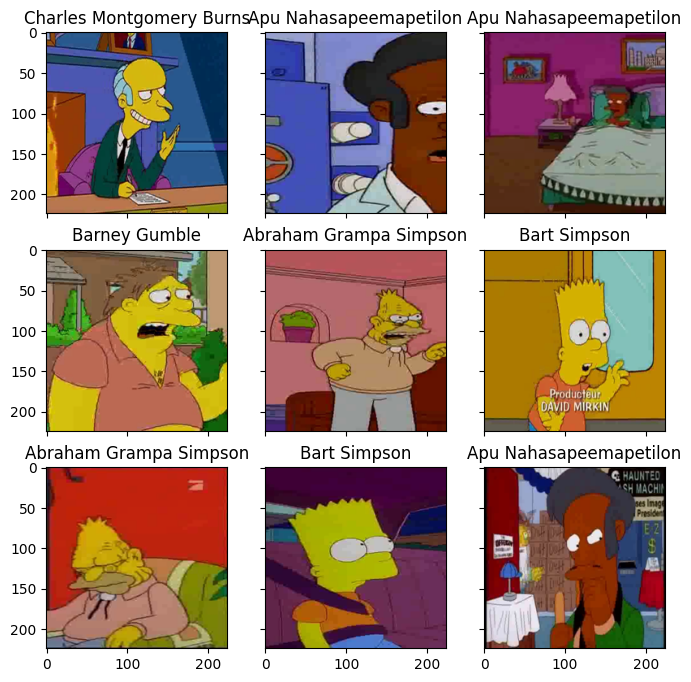

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [16]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [97]:
from sklearn.metrics import f1_score

def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [19]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [114]:
def train(train_dataset, val_dataset, model, epochs, batch_size, optimizer=torch.optim.Adam, lr=0.001, sampler=None, extended_val_dataset=None, parameters=None, gamma=0.1):
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    if extended_val_dataset:
        print(f"Extended validation dataset size: {len(extended_val_dataset)}")

    history = []

    if sampler is None:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    if extended_val_dataset:
      extended_val_loader = DataLoader(extended_val_dataset, batch_size=batch_size, shuffle=False)
      log_template = "\nEpoch {ep:03d}; \t train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} ext_val_loss {ext_v_loss:0.4f}; \
    train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} ext_val_acc {ext_v_acc:0.4f};"
    else:
      extended_val_loader = None
      log_template = "\nEpoch {ep:03d}; \t train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}; \
    train_acc {t_acc:0.4f} val_acc {v_acc:0.4f};"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        if parameters:
            opt = optimizer(parameters, lr=lr)
        else:
            opt = optimizer(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=gamma)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            if extended_val_loader:
                ext_val_loss, ext_val_acc = eval_epoch(model, extended_val_loader, criterion)

            if extended_val_loader:
                history.append((train_loss, train_acc, val_loss, val_acc, ext_val_loss, ext_val_acc))
            else:
                history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            if extended_val_loader:
                tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                            v_loss=val_loss, t_acc=train_acc, v_acc=val_acc,\
                                               ext_v_loss=ext_val_loss, ext_v_acc=ext_val_acc))
            else:
                tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                            v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [21]:
from sklearn.metrics import f1_score

def get_score(model, val_dataset):
    # idxs = list(map(int, np.random.uniform(0,len(dataset), 1000)))
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    total_labels = []
    total_preds = []

    with tqdm(desc="batch", total=len(val_loader)) as pbar_outer:
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
            total_labels += [label.cpu() for label in labels]
            total_preds += [pred.cpu() for pred in preds]
            pbar_outer.update(1)

    print(f"F1-score: {f1_score(total_labels, total_preds, average='micro')}")

In [22]:
def handle_history(history, model_type):
    if len(history[0]) == 4:
        loss, acc, val_loss, val_acc = zip(*history)
    elif len(history[0]) == 6:
        loss, acc, val_loss, val_acc, ext_val_loss, ext_val_acc = zip(*history)

    history_accuracy['train'][model_type] = acc
    history_accuracy['val'][model_type] = val_acc

    sns.set(style="whitegrid", font_scale=1.4)

    plt.figure(figsize=(16, 4))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    ax1.plot(history_accuracy['train'][model_type], marker='o', label="train_acc")
    ax1.plot([val.cpu() for val in history_accuracy['val'][model_type]],  marker='o', label="val_acc")
    if len(history[0]) == 6:
        ax1.plot([val.cpu() for val in ext_val_acc],  marker='o', label="ext_val_acc")

    ax1.legend(loc='best')
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("acc")

    ax2.plot(loss, marker='o', label="train_loss")
    ax2.plot(val_loss,  marker='o', label="val_loss")
    if len(history[0]) == 6:
        ax2.plot(ext_val_loss,  marker='o', label="ext_val_loss")

    ax2.legend(loc='best')
    ax2.set_xlabel("epochs")
    ax2.set_ylabel("loss")

    plt.show()

In [23]:
def predict(model, loader):
    with torch.no_grad():
        logits = []

        for inputs in loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [24]:
history_accuracy = {
    'train': {

    },
    'val': {

    }
}

In [25]:
n_classes = len(np.unique(train_val_labels))
classes = np.unique(train_val_labels)

In [24]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print(simple_cnn)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_features=42, bias=True)


Запустим обучение сети.

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=64)

In [ ]:
torch.save(simple_cnn.state_dict(), 'simple_cnn.pth')

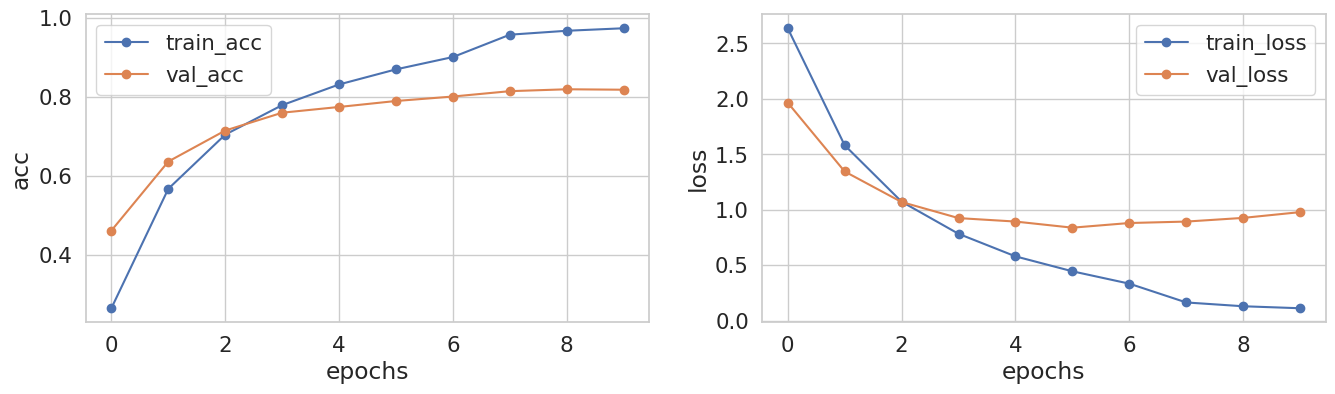

In [ ]:
handle_history(history, 'simple cnn')

In [26]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [27]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [28]:
from sklearn.metrics import f1_score

def get_score(model, val_dataset):
    # idxs = list(map(int, np.random.uniform(0,len(dataset), 1000)))
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    total_labels = []
    total_preds = []

    with tqdm(desc="batch", total=len(val_loader)) as pbar_outer:
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
            total_labels += [label.cpu() for label in labels]
            total_preds += [pred.cpu() for pred in preds]
            pbar_outer.update(1)

    print(f"F1-score: {f1_score(total_labels, total_preds, average='micro')}")

In [ ]:
get_score(simple_cnn, val_dataset)

batch: 100%|██████████| 82/82 [00:31<00:00,  2.60it/s]


F1-score: 0.8179212839128774


**Замечание.** В задаче мультиклассовой классификации с единственными лейблом *micro-averaged f1_score* совпадает с *accuracy*.

In [29]:
import pandas as pd

def submit(model, file_name):
  test_dataset = SimpsonsDataset(test_files, mode="test")
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

  probs = predict(model, test_loader)
  preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
  test_filenames = [path.name for path in test_dataset.files]

  my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
  my_submit.to_csv(file_name, index=False)

In [ ]:
submit(simple_cnn, "simple_cnn.csv")

In [30]:
def analyze_model(model, val_dataset):
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    probas = {

    }

    with tqdm(desc="batch", total=len(val_loader)) as pbar_outer:
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                probs = [nn.functional.softmax(output.cpu(), dim=-1).numpy() for output in outputs]
                preds = np.argmax(probs, -1)
                for i, pred in enumerate(preds):
                    character = label_encoder.classes_[pred]
                    if character not in probas.keys():
                        probas[character] = []
                    probas[character].append(probs[i][pred])
            pbar_outer.update(1)

    average_proba = {

    }

    for class_id in range(n_classes):
        character = label_encoder.classes_[class_id]
        if character in probas.keys():
            average_proba[character] = np.mean(probas[character])

    average_proba = dict(sorted(average_proba.items(), key=lambda item: item[1]))
    sns.set(style="whitegrid", font_scale=0.7)
    plt.barh(list(average_proba.keys()), list(average_proba.values()))

batch: 100%|██████████| 82/82 [00:32<00:00,  2.55it/s]


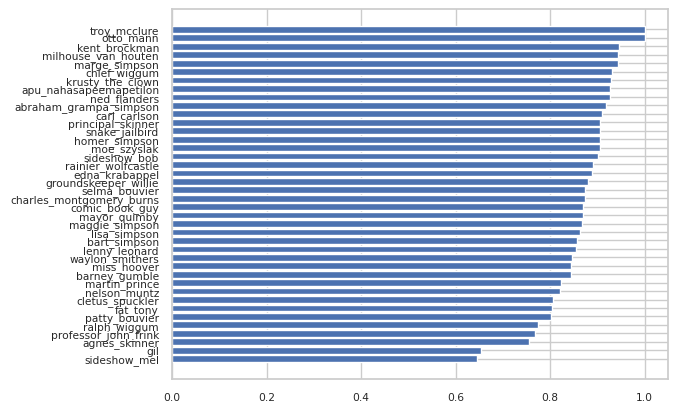

In [ ]:
analyze_model(simple_cnn, val_dataset)

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

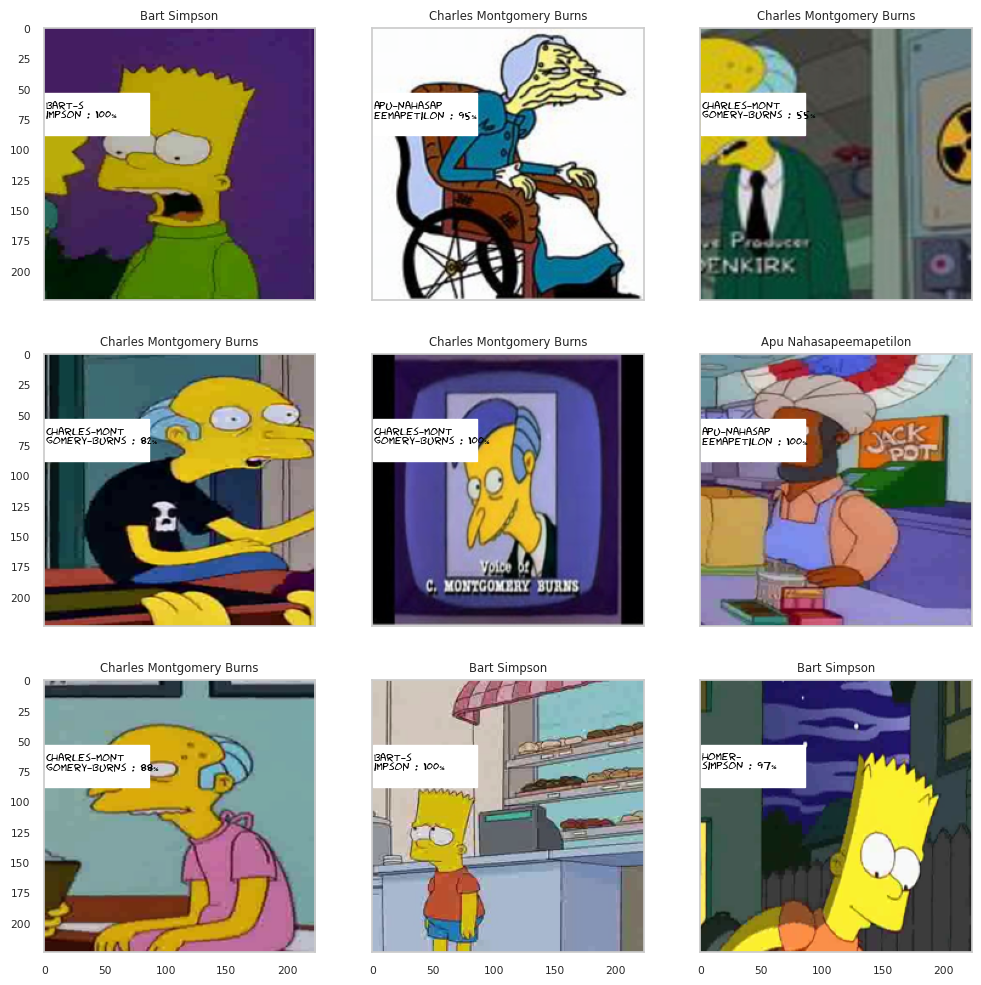

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

Посчитаем для каждого класса таргета, какую часть объектов валидационной выборки наша сеть распознала:

In [30]:
idxs = range(len(val_dataset))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(simple_cnn, imgs)
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [31]:
from sklearn.metrics import recall_score

recalls = recall_score(actual_labels, preds_class, average=None)
sorted_recalls = sorted(dict(enumerate(recalls)).items(), key=lambda x: -x[1])

for element in sorted_recalls:
    character = label_encoder.classes_[element[0]]
    log_template = "Character: {}, \n\t recall: {}, \n\t train sample count: {}"
    print(log_template.format(character, element[1], train_dataset.labels.count(character)))

Character: sideshow_mel, 
	 recall: 0.9, 
	 train sample count: 30
Character: lisa_simpson, 
	 recall: 0.07374631268436578, 
	 train sample count: 1015
Character: sideshow_bob, 
	 recall: 0.0182648401826484, 
	 train sample count: 658
Character: abraham_grampa_simpson, 
	 recall: 0.0, 
	 train sample count: 685
Character: agnes_skinner, 
	 recall: 0.0, 
	 train sample count: 32
Character: apu_nahasapeemapetilon, 
	 recall: 0.0, 
	 train sample count: 467
Character: barney_gumble, 
	 recall: 0.0, 
	 train sample count: 80
Character: bart_simpson, 
	 recall: 0.0, 
	 train sample count: 1006
Character: carl_carlson, 
	 recall: 0.0, 
	 train sample count: 74
Character: charles_montgomery_burns, 
	 recall: 0.0, 
	 train sample count: 895
Character: chief_wiggum, 
	 recall: 0.0, 
	 train sample count: 739
Character: cletus_spuckler, 
	 recall: 0.0, 
	 train sample count: 35
Character: comic_book_guy, 
	 recall: 0.0, 
	 train sample count: 352
Character: disco_stu, 
	 recall: 0.0, 
	 train sa

Низкий recall для конкретного класса таргета объясняется следующими факторами:

1. Маленький размер тренировочной выборки $\Rightarrow$ необходима аугментация

2. У свёрточных слоёв сети отсутствует свойство spatial independency $\Rightarrow$ необходимо применять батчнорм

3. Плохое качество картинок $\Rightarrow$ было бы логично использовать ядра разных размеров

4. И другие причины, которые будут упомянуты ниже

### Улучшение 1: добавим в нашу модель ещё пару полносвязных слоёв и батчнорм

In [32]:
class ExtendedCnn(nn.Module):
    def __init__(self, n_classes, classifier):
        super().__init__()
        self.CNN = CNN()
        self.classifier = classifier(96 * 5 * 5, n_classes)

    def forward(self, x):
        x = self.CNN(x)
        logits = self.classifier(x)
        return logits

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        return x.view(x.size(0), -1)

In [34]:
class Classifier(nn.Module):
    def __init__(self, input_size, n_classes):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, 4096),
            nn.ReLU(),
            nn.BatchNorm1d(4096)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024)
        )
        self.out = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        logits = self.out(x)
        return logits

In [ ]:
extended_cnn = ExtendedCnn(n_classes, Classifier).to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=extended_cnn, epochs=10, batch_size=64)

Train dataset size: 15699
Validation dataset size: 5234


epoch:  10%|█         | 1/10 [02:46<24:59, 166.57s/it]


Epoch 001; 	rain_loss: 1.7532 val_loss 1.1712;     train_acc 0.5454 val_acc 0.6817;


epoch:  20%|██        | 2/10 [05:26<21:40, 162.56s/it]


Epoch 002; 	rain_loss: 1.0027 val_loss 1.0737;     train_acc 0.7223 val_acc 0.7056;


epoch:  30%|███       | 3/10 [08:08<18:58, 162.60s/it]


Epoch 003; 	rain_loss: 0.6975 val_loss 0.8588;     train_acc 0.7993 val_acc 0.7694;


epoch:  40%|████      | 4/10 [10:49<16:11, 161.87s/it]


Epoch 004; 	rain_loss: 0.4940 val_loss 0.8554;     train_acc 0.8590 val_acc 0.7868;


epoch:  50%|█████     | 5/10 [13:32<13:31, 162.34s/it]


Epoch 005; 	rain_loss: 0.3580 val_loss 0.9103;     train_acc 0.8943 val_acc 0.8007;


epoch:  60%|██████    | 6/10 [16:13<10:46, 161.72s/it]


Epoch 006; 	rain_loss: 0.2839 val_loss 0.9989;     train_acc 0.9159 val_acc 0.7979;


epoch:  70%|███████   | 7/10 [18:50<08:00, 160.30s/it]


Epoch 007; 	rain_loss: 0.2271 val_loss 0.9587;     train_acc 0.9334 val_acc 0.8093;


epoch:  80%|████████  | 8/10 [21:32<05:21, 160.66s/it]


Epoch 008; 	rain_loss: 0.0501 val_loss 0.7330;     train_acc 0.9857 val_acc 0.8594;


epoch:  90%|█████████ | 9/10 [24:12<02:40, 160.57s/it]


Epoch 009; 	rain_loss: 0.0067 val_loss 0.7514;     train_acc 0.9992 val_acc 0.8601;


epoch: 100%|██████████| 10/10 [26:53<00:00, 161.34s/it]


Epoch 010; 	rain_loss: 0.0032 val_loss 0.7693;     train_acc 0.9998 val_acc 0.8619;


In [ ]:
torch.save(extended_cnn, 'extended_cnn.pth')

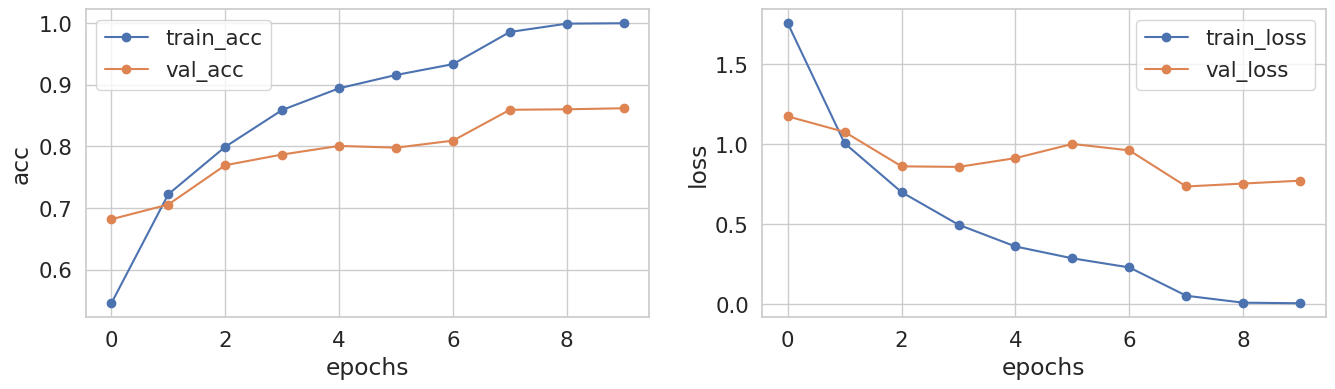

In [ ]:
handle_history(history, 'Extended CNN')

In [ ]:
get_score(extended_cnn, val_dataset)

batch: 100%|██████████| 82/82 [00:36<00:00,  2.22it/s]


F1-score: 0.861864730607566


batch: 100%|██████████| 82/82 [00:35<00:00,  2.28it/s]


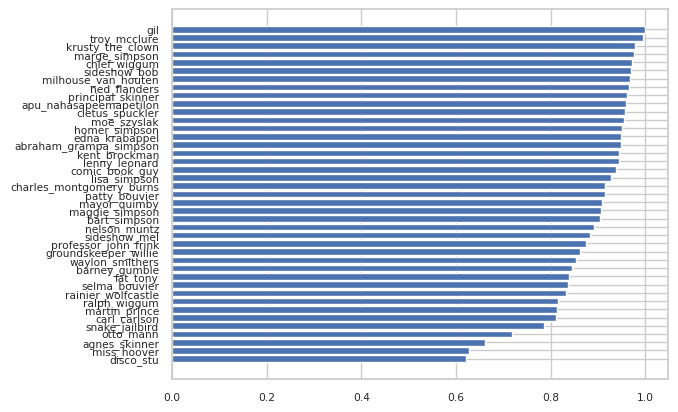

In [ ]:
analyze_model(extended_cnn, val_dataset)

In [ ]:
submit(extended_cnn, "extended_cnn.csv")

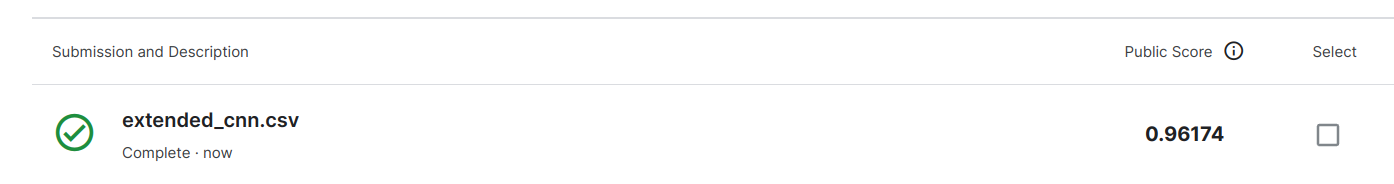

Такую большую разницу в скоре (по сравнению с качеством на валидационной выборке) можно объяснить слабым набором тестов на каггле. Иначе говоря, те классы, которые модель идентефицирует плохо, попадаются в тестовой выборке редко.

### Улучшение 2: сбалансируем классы для даталоадера тренировочной выборки

In [31]:
from torch.utils.data.sampler import WeightedRandomSampler

def get_sampler(dataset):
    weights = np.zeros(n_classes)
    for class_id, character in enumerate(classes):
        weights[class_id] = 1 / dataset.labels.count(character)

    samples_weights = np.zeros(len(dataset))
    for i, character in enumerate(dataset.labels):
        class_id = dataset.label_encoder.transform([character])[0]
        samples_weights[i] = weights[class_id]

    samples_weights = torch.from_numpy(samples_weights)

    return WeightedRandomSampler(samples_weights, num_samples=len(samples_weights))

In [36]:
sampler = get_sampler(train_dataset)

In [ ]:
extended_cnn_balanced = ExtendedCnn(n_classes, Classifier).to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=extended_cnn_balanced, epochs=20, batch_size=64, sampler=sampler)

Train dataset size: 15699
Validation dataset size: 5234


epoch:   5%|▌         | 1/20 [02:24<45:36, 144.01s/it]


Epoch 001; 	rain_loss: 1.2330 val_loss 1.6089;     train_acc 0.6821 val_acc 0.5711;


epoch:  10%|█         | 2/20 [04:41<42:04, 140.27s/it]


Epoch 002; 	rain_loss: 0.6594 val_loss 1.7495;     train_acc 0.8203 val_acc 0.5520;


epoch:  15%|█▌        | 3/20 [07:04<40:07, 141.59s/it]


Epoch 003; 	rain_loss: 0.4992 val_loss 1.4690;     train_acc 0.8625 val_acc 0.6200;


epoch:  20%|██        | 4/20 [09:24<37:32, 140.76s/it]


Epoch 004; 	rain_loss: 0.3789 val_loss 1.2627;     train_acc 0.8945 val_acc 0.6813;


epoch:  25%|██▌       | 5/20 [11:44<35:09, 140.63s/it]


Epoch 005; 	rain_loss: 0.3381 val_loss 1.4029;     train_acc 0.9063 val_acc 0.6777;


epoch:  30%|███       | 6/20 [14:03<32:40, 140.05s/it]


Epoch 006; 	rain_loss: 0.2879 val_loss 1.4242;     train_acc 0.9215 val_acc 0.6788;


epoch:  35%|███▌      | 7/20 [16:22<30:16, 139.75s/it]


Epoch 007; 	rain_loss: 0.2597 val_loss 1.3001;     train_acc 0.9293 val_acc 0.7247;


epoch:  40%|████      | 8/20 [18:39<27:47, 138.92s/it]


Epoch 008; 	rain_loss: 0.1110 val_loss 0.8814;     train_acc 0.9697 val_acc 0.7906;


epoch:  45%|████▌     | 9/20 [20:55<25:15, 137.76s/it]


Epoch 009; 	rain_loss: 0.0754 val_loss 0.8643;     train_acc 0.9789 val_acc 0.8032;


epoch:  50%|█████     | 10/20 [23:14<23:01, 138.18s/it]


Epoch 010; 	rain_loss: 0.0440 val_loss 0.8687;     train_acc 0.9878 val_acc 0.8093;


epoch:  55%|█████▌    | 11/20 [25:28<20:33, 137.06s/it]


Epoch 011; 	rain_loss: 0.0373 val_loss 0.8794;     train_acc 0.9902 val_acc 0.8133;


epoch:  60%|██████    | 12/20 [27:44<18:13, 136.64s/it]


Epoch 012; 	rain_loss: 0.0296 val_loss 0.8714;     train_acc 0.9921 val_acc 0.8173;


epoch:  65%|██████▌   | 13/20 [30:03<16:00, 137.22s/it]


Epoch 013; 	rain_loss: 0.0215 val_loss 0.8836;     train_acc 0.9946 val_acc 0.8261;


epoch:  70%|███████   | 14/20 [32:17<13:38, 136.41s/it]


Epoch 014; 	rain_loss: 0.0140 val_loss 0.8959;     train_acc 0.9965 val_acc 0.8238;


epoch:  75%|███████▌  | 15/20 [34:33<11:21, 136.25s/it]


Epoch 015; 	rain_loss: 0.0116 val_loss 0.8982;     train_acc 0.9968 val_acc 0.8242;


epoch:  80%|████████  | 16/20 [36:52<09:07, 136.98s/it]


Epoch 016; 	rain_loss: 0.0111 val_loss 0.9006;     train_acc 0.9971 val_acc 0.8254;


epoch:  85%|████████▌ | 17/20 [39:05<06:48, 136.03s/it]


Epoch 017; 	rain_loss: 0.0101 val_loss 0.9048;     train_acc 0.9980 val_acc 0.8267;


epoch:  90%|█████████ | 18/20 [41:23<04:32, 136.45s/it]


Epoch 018; 	rain_loss: 0.0091 val_loss 0.9135;     train_acc 0.9981 val_acc 0.8261;


epoch:  95%|█████████▌| 19/20 [43:39<02:16, 136.27s/it]


Epoch 019; 	rain_loss: 0.0067 val_loss 0.9183;     train_acc 0.9985 val_acc 0.8265;


epoch: 100%|██████████| 20/20 [45:54<00:00, 137.74s/it]


Epoch 020; 	rain_loss: 0.0077 val_loss 0.9222;     train_acc 0.9985 val_acc 0.8273;


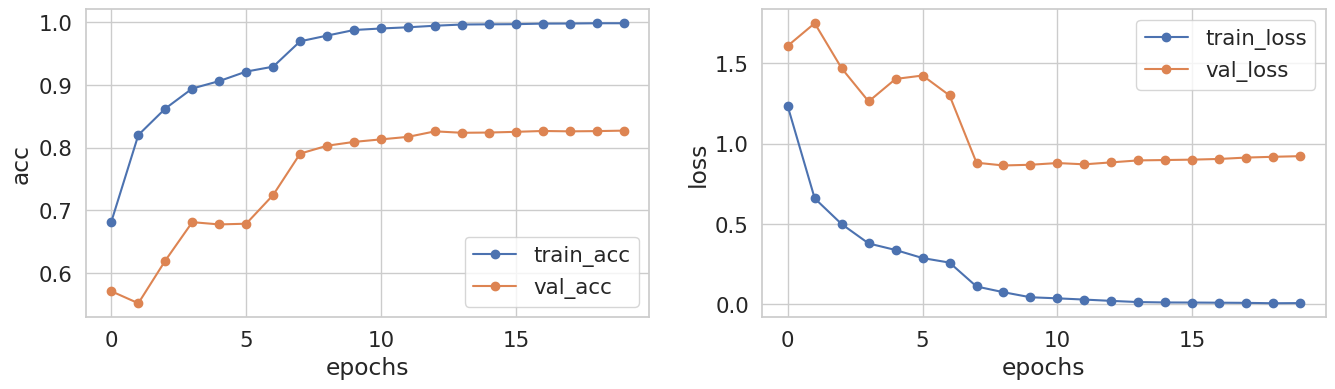

In [ ]:
handle_history(history, 'Extended CNN, balanced')

In [ ]:
torch.save(extended_cnn_balanced.state_dict(), 'extended_cnn_balanced.pth')

batch: 100%|██████████| 82/82 [00:31<00:00,  2.58it/s]


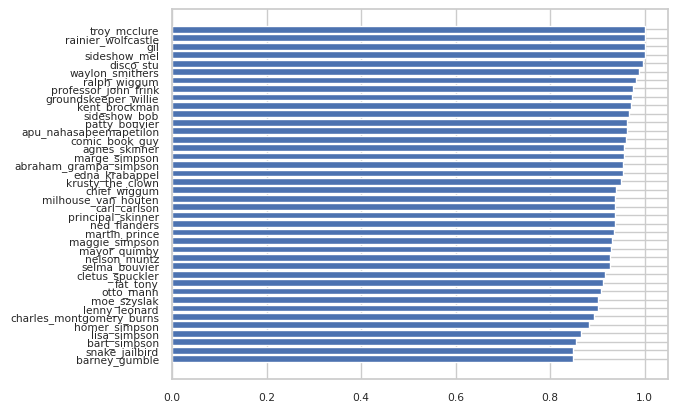

In [ ]:
analyze_model(extended_cnn_balanced, val_dataset)

In [ ]:
get_score(extended_cnn_balanced, val_dataset)

batch: 100%|██████████| 82/82 [00:31<00:00,  2.61it/s]


F1-score: 0.827283148643485


In [ ]:
submit(extended_cnn_balanced, "extended_cnn_balanced.csv")

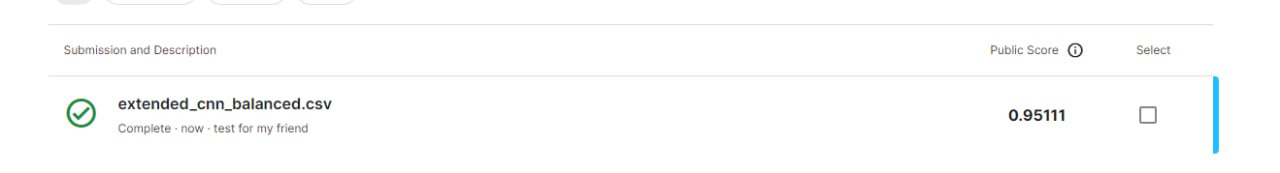

Скор немного ухудшился.

### Улучшение 3: добавим к тренировочной выборке её аугментации

Изучим распределение таргета:

In [39]:
def analyze_label_distribution(dataset):
    labels_count = {}
    for character in classes:
        labels_count[character] = dataset.labels.count(character)
    labels_count = dict(sorted(labels_count.items(), key=lambda item: item[1]))
    sns.set(style="whitegrid", font_scale=0.7)
    plt.barh(list(labels_count.keys()), list(labels_count.values()))

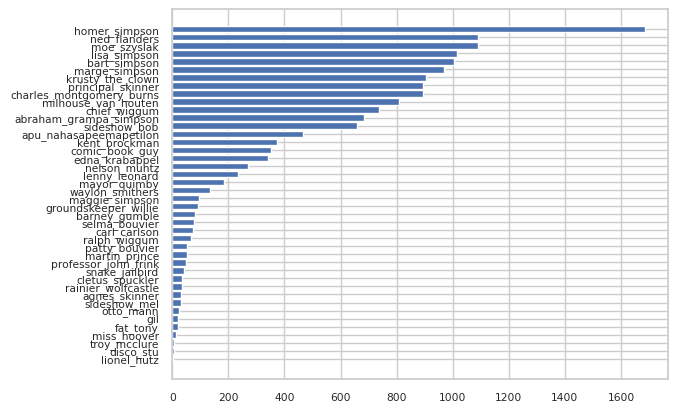

In [38]:
analyze_label_distribution(train_dataset)

In [33]:
def augment_by_label(dataset, label):
    resize_cropper = v2.RandomResizedCrop(size=(RESCALE_SIZE, RESCALE_SIZE))
    resize_cropper_count = 30
    blurrer = v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
    blurer_count = 30
    horizontal_flipper = v2.RandomHorizontalFlip(p=1)
    horizontal_flipper_count = 1
    resize_count = 10
    center_crop_count = 10

    ids = [id for id in range(dataset.len_) if dataset.labels[id] == label]
    initial_count = len(ids)
    transforms_count = resize_cropper_count + blurer_count + horizontal_flipper_count + resize_count + center_crop_count

    augmentations_per_image = min(AUGMENT_COUNT // initial_count + 1, transforms_count)
    augmented_count = 0

    if GOOGLE_COLAB_SPACE:
        Path(f"./{AUGMENTED_DIR.as_posix()}/simpsons_dataset/{label}").mkdir(parents=True, exist_ok=True)
    else:
        Path(f"./{AUGMENTED_DIR.as_posix()}/simpsons_dataset/{label}").mkdir(parents=True, exist_ok=True)
    for j, id in enumerate(ids):
        if initial_count + augmented_count >= AUGMENT_COUNT:
            break
        file = dataset.files[id]
        image = dataset.load_sample(file)
        augmented_imgs = []
        augmented_imgs += [resize_cropper(image) for _ in range(30)]
        augmented_imgs += [blurrer(image) for _ in range(30)]
        augmented_imgs += [horizontal_flipper(image)]
        augmented_imgs += [v2.Resize(size=(size, size))(image) for size in np.linspace(100, 200, resize_count).astype(int)]
        augmented_imgs += [v2.CenterCrop(size=size)(image) for size in np.linspace(100, 200, center_crop_count).astype(int)]
        for i in np.random.choice(np.arange(len(augmented_imgs)),
                                    size=min(AUGMENT_COUNT - (initial_count + augmented_count), augmentations_per_image),
                                            replace=False):
            if GOOGLE_COLAB_SPACE:
                augmented_imgs[i].save(f"./{AUGMENTED_DIR.as_posix()}/simpsons_dataset/{label}/aug_{augmented_count}.jpg")
            else:
                augmented_imgs[i].save(f".\\{str(AUGMENTED_DIR)}\\simpsons_dataset\\{label}\\aug_{augmented_count}.jpg")
            augmented_count += 1

    return augmented_imgs

In [41]:
if GOOGLE_COLAB_SPACE:
    !rm -rf augmented
else:
    !rmdir augmented

The system cannot find the file specified.


In [35]:
if GOOGLE_COLAB_SPACE:
    AUGMENTED_DIR = Path('./augmented/')
    Path("./augmented").mkdir(parents=True, exist_ok=True)
else:
    AUGMENTED_DIR = Path('./journey-springfield/augmented/')
    Path("./journey-springfield/augmented").mkdir(parents=True, exist_ok=True)

In [49]:
augmented_images = []
for character in tqdm(classes):
    if train_dataset.labels.count(character) < AUGMENT_COUNT:
        augmented_images.append(augment_by_label(train_dataset, character)[np.random.choice(8)])

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [04:28<00:00,  6.40s/it]


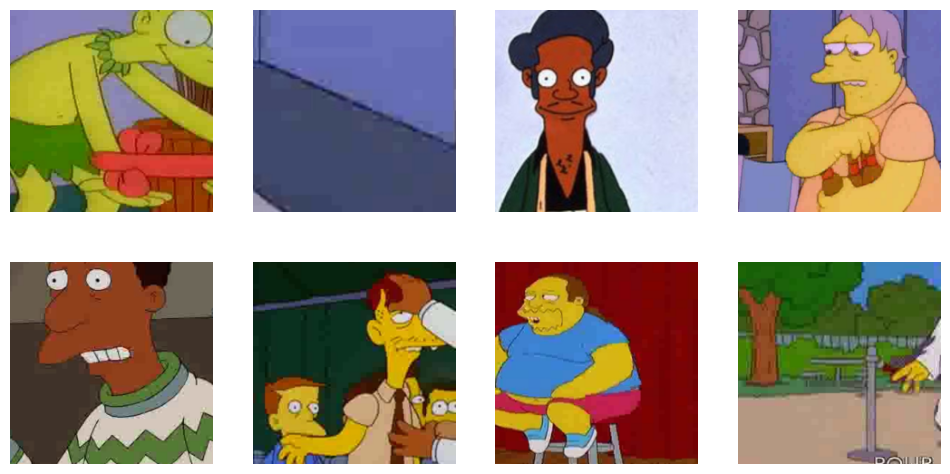

In [43]:
plt.figure(figsize=(12, 6))

for i, img in enumerate(augmented_images[:8]):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')

In [36]:
augmented_train_files = sorted(list(AUGMENTED_DIR.rglob('*.jpg')))
extended_train_files = train_files + augmented_train_files
extended_train_dataset = SimpsonsDataset(extended_train_files, mode='train')

In [37]:
len(extended_train_dataset.labels)

26681

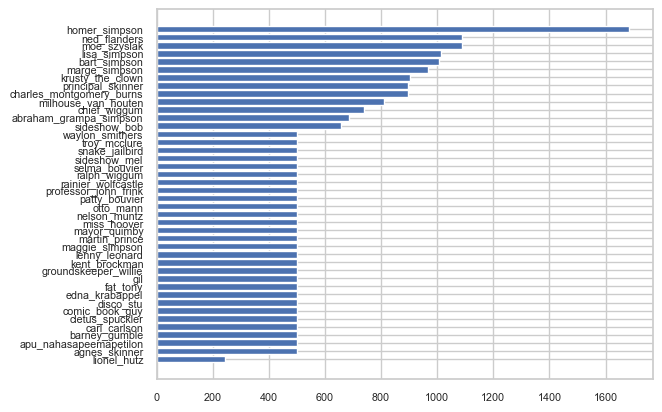

In [40]:
analyze_label_distribution(extended_train_dataset)

Сбалансируем классы в батчах:

In [47]:
sampler = get_sampler(extended_train_dataset)

In [48]:
extended_cnn_augmented_balanced = ExtendedCnn(n_classes, Classifier).to(DEVICE)

In [49]:
history = train(extended_train_dataset, val_dataset, model=extended_cnn_augmented_balanced, epochs=20, batch_size=64, sampler=sampler)

Train dataset size: 26585
Validation dataset size: 5234


epoch:   5%|▌         | 1/20 [03:12<1:01:05, 192.90s/it]


Epoch 001; 	rain_loss: 1.5665 val_loss 1.5089;     train_acc 0.5897 val_acc 0.6026;


epoch:  10%|█         | 2/20 [06:24<57:34, 191.93s/it]


Epoch 002; 	rain_loss: 0.7938 val_loss 1.3534;     train_acc 0.7841 val_acc 0.6584;


epoch:  15%|█▌        | 3/20 [09:33<54:01, 190.65s/it]


Epoch 003; 	rain_loss: 0.5245 val_loss 1.0495;     train_acc 0.8565 val_acc 0.7318;


epoch:  20%|██        | 4/20 [12:42<50:40, 190.02s/it]


Epoch 004; 	rain_loss: 0.4106 val_loss 1.2222;     train_acc 0.8893 val_acc 0.7104;


epoch:  25%|██▌       | 5/20 [15:46<46:59, 187.93s/it]


Epoch 005; 	rain_loss: 0.3173 val_loss 1.0234;     train_acc 0.9128 val_acc 0.7554;


epoch:  30%|███       | 6/20 [18:42<42:54, 183.91s/it]


Epoch 006; 	rain_loss: 0.2434 val_loss 1.0246;     train_acc 0.9330 val_acc 0.7728;


epoch:  35%|███▌      | 7/20 [21:38<39:16, 181.28s/it]


Epoch 007; 	rain_loss: 0.2207 val_loss 1.1494;     train_acc 0.9400 val_acc 0.7684;


epoch:  40%|████      | 8/20 [24:42<36:23, 181.98s/it]


Epoch 008; 	rain_loss: 0.0699 val_loss 0.8106;     train_acc 0.9815 val_acc 0.8290;


epoch:  45%|████▌     | 9/20 [27:46<33:30, 182.79s/it]


Epoch 009; 	rain_loss: 0.0269 val_loss 0.7943;     train_acc 0.9931 val_acc 0.8389;


epoch:  50%|█████     | 10/20 [30:43<30:08, 180.84s/it]


Epoch 010; 	rain_loss: 0.0165 val_loss 0.8083;     train_acc 0.9962 val_acc 0.8428;


epoch:  55%|█████▌    | 11/20 [33:39<26:54, 179.36s/it]


Epoch 011; 	rain_loss: 0.0095 val_loss 0.8346;     train_acc 0.9979 val_acc 0.8399;


epoch:  60%|██████    | 12/20 [36:38<23:55, 179.41s/it]


Epoch 012; 	rain_loss: 0.0055 val_loss 0.8431;     train_acc 0.9989 val_acc 0.8468;


epoch:  65%|██████▌   | 13/20 [39:42<21:06, 180.86s/it]


Epoch 013; 	rain_loss: 0.0035 val_loss 0.9164;     train_acc 0.9991 val_acc 0.8414;


epoch:  70%|███████   | 14/20 [42:47<18:12, 182.13s/it]


Epoch 014; 	rain_loss: 0.0025 val_loss 0.8967;     train_acc 0.9995 val_acc 0.8468;


epoch:  75%|███████▌  | 15/20 [45:44<15:01, 180.40s/it]


Epoch 015; 	rain_loss: 0.0020 val_loss 0.9005;     train_acc 0.9995 val_acc 0.8485;


epoch:  80%|████████  | 16/20 [48:42<11:58, 179.65s/it]


Epoch 016; 	rain_loss: 0.0011 val_loss 0.9062;     train_acc 0.9998 val_acc 0.8477;


epoch:  85%|████████▌ | 17/20 [51:49<09:05, 181.92s/it]


Epoch 017; 	rain_loss: 0.0011 val_loss 0.9137;     train_acc 0.9999 val_acc 0.8472;


epoch:  90%|█████████ | 18/20 [54:56<06:07, 183.57s/it]


Epoch 018; 	rain_loss: 0.0009 val_loss 0.9199;     train_acc 0.9998 val_acc 0.8479;


epoch:  95%|█████████▌| 19/20 [57:59<03:03, 183.25s/it]


Epoch 019; 	rain_loss: 0.0008 val_loss 0.9250;     train_acc 0.9998 val_acc 0.8468;


epoch: 100%|██████████| 20/20 [1:00:57<00:00, 182.89s/it]


Epoch 020; 	rain_loss: 0.0007 val_loss 0.9326;     train_acc 0.9999 val_acc 0.8479;


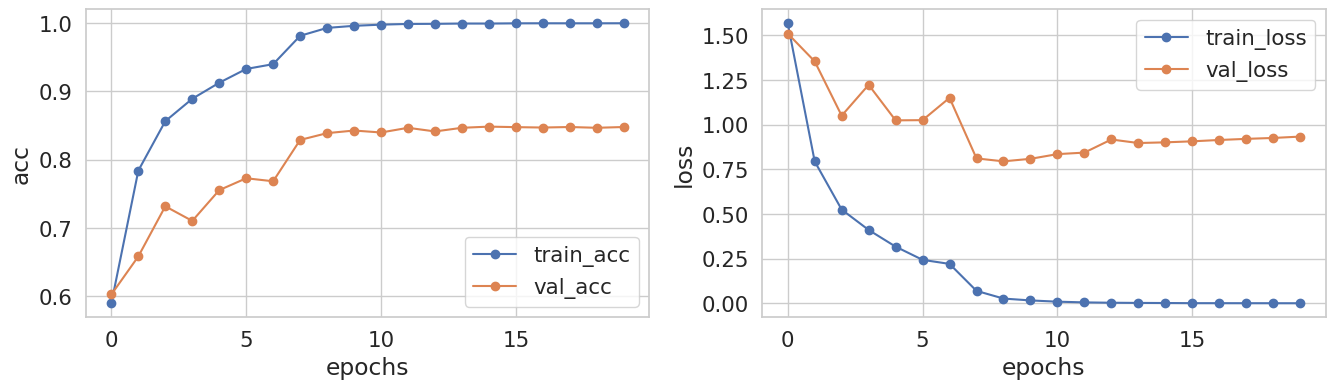

In [50]:
handle_history(history, 'Extended CNN, augmented, balanced, v.1')

In [51]:
torch.save(extended_cnn_augmented_balanced.state_dict(), 'extended_cnn_augmented_balanced_v1.pth')

batch: 100%|██████████| 82/82 [00:31<00:00,  2.57it/s]


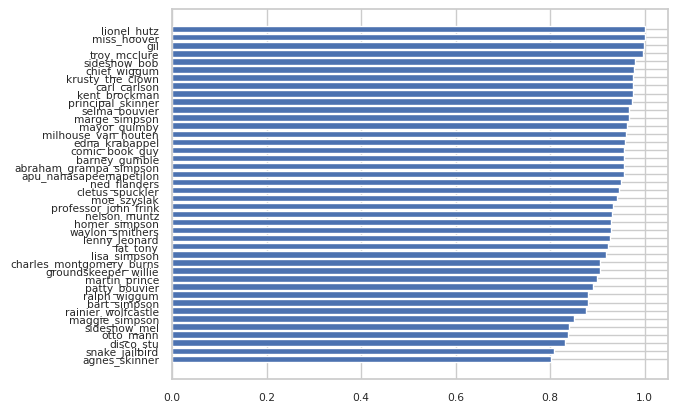

In [52]:
analyze_model(extended_cnn_augmented_balanced, val_dataset)

In [53]:
get_score(extended_cnn_augmented_balanced, val_dataset)

batch: 100%|██████████| 82/82 [00:37<00:00,  2.19it/s]


F1-score: 0.8479174627435996


In [56]:
submit(extended_cnn_augmented_balanced, "extended_cnn_augmented_balanced_v1.csv")

Отметим, что скор на расширенной тренировочной и исходной валидационной выборке почти равен 1, в то время как на расширенной валидационной выборке он не превосходит 0.87.

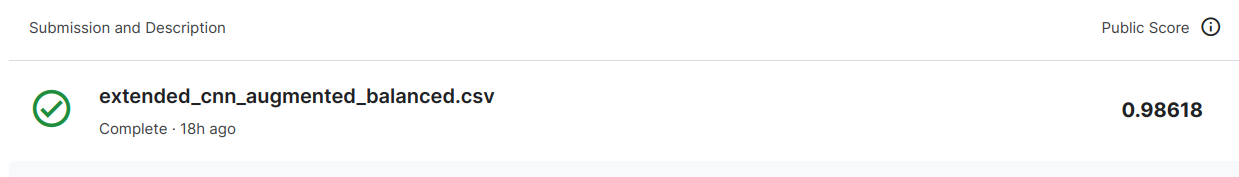

Таким образом, аугментация и балансировка классов позволяют увеличить скор на 2%.

### Улучшение 4: аугментируем весь тренировочный датасет

В силу небольшого числа картинок, логично было бы аугментировать всю тренировочную (вместе с валидационной) выборку. Аугментируем все картинки тренировочной и валидационной выборок, а далее заново разделим получившийся набор картинок:

In [ ]:
if GOOGLE_COLAB_SPACE:
    !rm -rf augmented
else:
    !rmdir augmented

In [ ]:
train_val_dataset = SimpsonsDataset(train_val_files, mode="train")
analyze_label_distribution(train_val_dataset)

In [ ]:
for element in tqdm(sorted_recalls):
    character = label_encoder.classes_[element[0]]
    if train_val_dataset.labels.count(character) < AUGMENT_COUNT:
        _ = augment_by_label(train_val_dataset, character)

100%|██████████| 42/42 [11:29<00:00, 16.41s/it]


In [116]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
augmented_train_val_files = sorted(list(AUGMENTED_DIR.rglob('*.jpg')))

extended_train_val_labels = [path.parent.name for path in train_val_files + augmented_train_val_files]
extended_train_files, extended_val_files = train_test_split(train_val_files + augmented_train_val_files, test_size=0.1, \
                                          stratify=extended_train_val_labels)

extended_val_dataset = SimpsonsDataset(extended_val_files, mode='val')
extended_train_dataset = SimpsonsDataset(extended_train_files, mode='train')

In [ ]:
extended_cnn_augmented_balanced_upd = ExtendedCnn(n_classes, Classifier).to(DEVICE)

In [ ]:
sampler = get_sampler(extended_train_dataset)

In [ ]:
history = train(extended_train_dataset, val_dataset, model=extended_cnn_augmented_balanced_upd, epochs=20, batch_size=64, sampler=sampler, extended_val_dataset=extended_val_dataset)

Train dataset size: 27860
Validation dataset size: 5234
Extended validation dataset size: 3096


epoch:   5%|▌         | 1/20 [03:56<1:14:45, 236.07s/it]


Epoch 001; 	rain_loss: 1.5000 val_loss 1.2195 ext_val_loss 1.2626;     train_acc 0.6133 val_acc 0.6733 ext_val_acc 0.6615;


epoch:  10%|█         | 2/20 [07:51<1:10:44, 235.79s/it]


Epoch 002; 	rain_loss: 0.7443 val_loss 0.9894 ext_val_loss 1.1962;     train_acc 0.7992 val_acc 0.7276 ext_val_acc 0.6922;


epoch:  15%|█▌        | 3/20 [11:46<1:06:38, 235.21s/it]


Epoch 003; 	rain_loss: 0.5208 val_loss 0.8303 ext_val_loss 1.1252;     train_acc 0.8559 val_acc 0.7853 ext_val_acc 0.7426;


epoch:  20%|██        | 4/20 [15:40<1:02:38, 234.92s/it]


Epoch 004; 	rain_loss: 0.3777 val_loss 0.5366 ext_val_loss 1.0259;     train_acc 0.8956 val_acc 0.8544 ext_val_acc 0.7668;


epoch:  25%|██▌       | 5/20 [19:37<58:54, 235.64s/it]


Epoch 005; 	rain_loss: 0.3270 val_loss 0.4777 ext_val_loss 0.9439;     train_acc 0.9113 val_acc 0.8699 ext_val_acc 0.7810;


epoch:  30%|███       | 6/20 [23:33<55:00, 235.74s/it]


Epoch 006; 	rain_loss: 0.2304 val_loss 0.3512 ext_val_loss 0.8876;     train_acc 0.9360 val_acc 0.9033 ext_val_acc 0.8007;


epoch:  35%|███▌      | 7/20 [27:34<51:24, 237.31s/it]


Epoch 007; 	rain_loss: 0.2082 val_loss 0.3589 ext_val_loss 1.0140;     train_acc 0.9441 val_acc 0.9108 ext_val_acc 0.7991;


epoch:  40%|████      | 8/20 [31:36<47:45, 238.81s/it]


Epoch 008; 	rain_loss: 0.0674 val_loss 0.1485 ext_val_loss 0.7481;     train_acc 0.9819 val_acc 0.9620 ext_val_acc 0.8404;


epoch:  45%|████▌     | 9/20 [35:35<43:48, 238.96s/it]


Epoch 009; 	rain_loss: 0.0278 val_loss 0.1162 ext_val_loss 0.7281;     train_acc 0.9926 val_acc 0.9733 ext_val_acc 0.8498;


epoch:  50%|█████     | 10/20 [39:04<38:16, 229.62s/it]


Epoch 010; 	rain_loss: 0.0164 val_loss 0.0976 ext_val_loss 0.7546;     train_acc 0.9956 val_acc 0.9778 ext_val_acc 0.8514;


epoch:  55%|█████▌    | 11/20 [42:24<33:05, 220.58s/it]


Epoch 011; 	rain_loss: 0.0108 val_loss 0.0919 ext_val_loss 0.7865;     train_acc 0.9975 val_acc 0.9807 ext_val_acc 0.8534;


epoch:  60%|██████    | 12/20 [45:45<28:36, 214.61s/it]


Epoch 012; 	rain_loss: 0.0098 val_loss 0.0826 ext_val_loss 0.7845;     train_acc 0.9982 val_acc 0.9828 ext_val_acc 0.8540;


epoch:  65%|██████▌   | 13/20 [49:05<24:32, 210.33s/it]


Epoch 013; 	rain_loss: 0.0045 val_loss 0.0792 ext_val_loss 0.8207;     train_acc 0.9990 val_acc 0.9843 ext_val_acc 0.8559;


epoch:  70%|███████   | 14/20 [52:24<20:41, 206.87s/it]


Epoch 014; 	rain_loss: 0.0057 val_loss 0.0748 ext_val_loss 0.8301;     train_acc 0.9989 val_acc 0.9857 ext_val_acc 0.8550;


epoch:  75%|███████▌  | 15/20 [55:40<16:57, 203.49s/it]


Epoch 015; 	rain_loss: 0.0021 val_loss 0.0734 ext_val_loss 0.8256;     train_acc 0.9994 val_acc 0.9861 ext_val_acc 0.8550;


epoch:  80%|████████  | 16/20 [58:55<13:23, 201.00s/it]


Epoch 016; 	rain_loss: 0.0018 val_loss 0.0719 ext_val_loss 0.8271;     train_acc 0.9996 val_acc 0.9864 ext_val_acc 0.8569;


epoch:  85%|████████▌ | 17/20 [1:02:09<09:56, 198.98s/it]


Epoch 017; 	rain_loss: 0.0012 val_loss 0.0718 ext_val_loss 0.8352;     train_acc 0.9998 val_acc 0.9866 ext_val_acc 0.8559;


epoch:  90%|█████████ | 18/20 [1:05:23<06:34, 197.34s/it]


Epoch 018; 	rain_loss: 0.0013 val_loss 0.0713 ext_val_loss 0.8410;     train_acc 0.9997 val_acc 0.9874 ext_val_acc 0.8556;


epoch:  95%|█████████▌| 19/20 [1:08:36<03:16, 196.03s/it]


Epoch 019; 	rain_loss: 0.0012 val_loss 0.0713 ext_val_loss 0.8483;     train_acc 0.9999 val_acc 0.9880 ext_val_acc 0.8572;


epoch: 100%|██████████| 20/20 [1:11:48<00:00, 215.42s/it]


Epoch 020; 	rain_loss: 0.0009 val_loss 0.0714 ext_val_loss 0.8520;     train_acc 0.9999 val_acc 0.9880 ext_val_acc 0.8563;


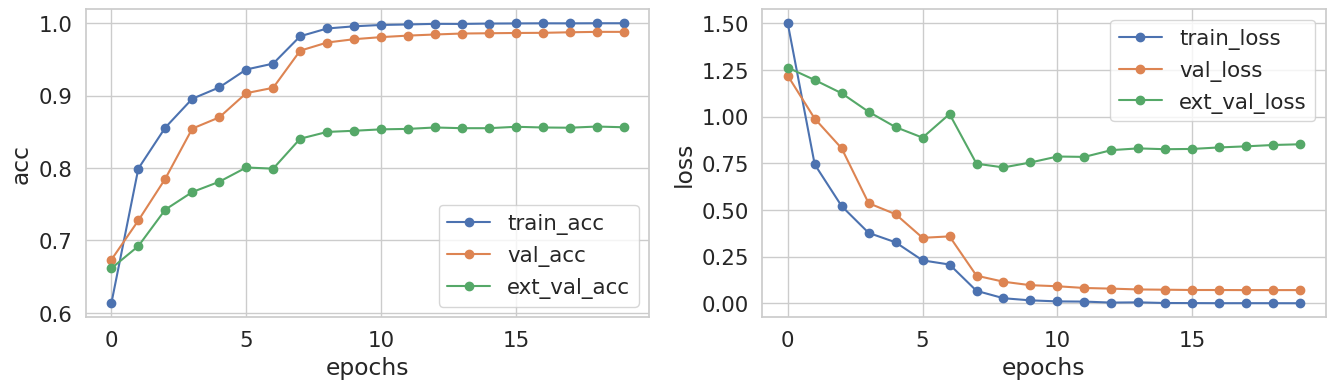

In [ ]:
handle_history(history, 'Extended CNN, augmented, balanced, v.2')

In [ ]:
torch.save(extended_cnn_augmented_balanced_upd.state_dict(), 'extended_cnn_augmented_balanced_v2.pth')

batch: 100%|██████████| 82/82 [00:57<00:00,  1.43it/s]


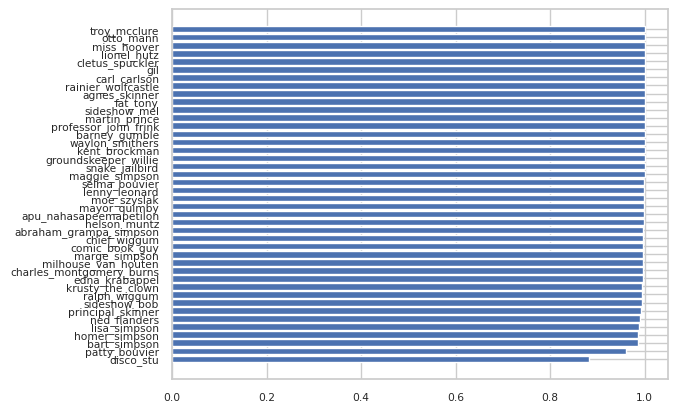

In [ ]:
analyze_model(extended_cnn_augmented_balanced_upd, val_dataset)

In [ ]:
submit(extended_cnn_augmented_balanced_upd, "extended_cnn_augmented_balanced_upd.csv")

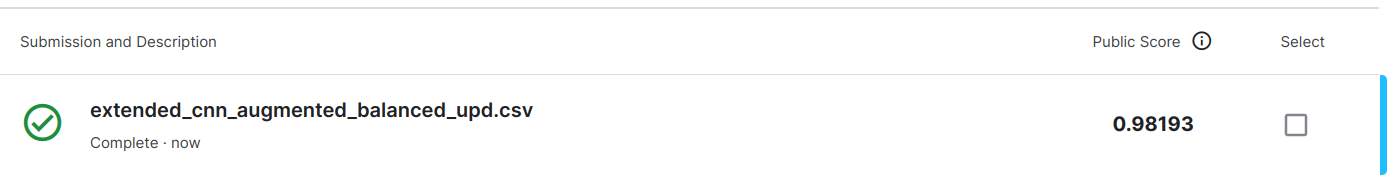

Обучая модель на аугментациях валидационной выборки мы поступаем не совсем честно, ведь таким образом часть информации валидационной выборки утекает во время обучения модели: мы попросту используем для обучения преобразования валидационных картинок. Такое решение можно объяснить небольшим размером валидационной выборки.

### Fine-tuning

## Inception

In [77]:
from torchvision import models

In [ ]:
model_extractor = models.inception_v3(pretrained=True)

In [92]:
torch.cuda.empty_cache()

In [93]:
!nvidia-smi

Thu Nov 16 20:49:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  | 00000000:09:00.0  On |                  N/A |
| 30%   50C    P8              21W / 200W |   2596MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [84]:
for param in model_extractor.parameters():
    param.requires_grad = False

In [85]:
model_extractor.AuxLogits.fc = nn.Linear(768, n_classes)
model_extractor.fc =  nn.Linear(2048, n_classes)
model_extractor.classifier = nn.Linear(25048, n_classes)

In [86]:
model_extractor.aux_logits = False
model_extractor = model_extractor.cuda()

In [87]:
RESCALE_SIZE = 299

In [75]:
sampler = get_sampler(extended_train_dataset)

In [98]:
history = train(extended_train_dataset, val_dataset, model_extractor, epochs=10, batch_size=64, sampler=sampler, parameters=model_extractor.parameters())

Train dataset size: 26681
Validation dataset size: 5234


epoch:  10%|███████▌                                                                   | 1/10 [03:21<30:16, 201.84s/it]


Epoch 001; 	rain_loss: 1.5471 val_loss 1.5635;     train_acc 0.6486 val_acc 0.6024;


epoch:  20%|███████████████                                                            | 2/10 [06:40<26:40, 200.04s/it]


Epoch 002; 	rain_loss: 1.0929 val_loss 1.5285;     train_acc 0.7420 val_acc 0.5917;


epoch:  30%|██████████████████████▌                                                    | 3/10 [09:58<23:12, 198.96s/it]


Epoch 003; 	rain_loss: 0.8897 val_loss 1.2641;     train_acc 0.7880 val_acc 0.6693;


epoch:  40%|██████████████████████████████                                             | 4/10 [13:13<19:44, 197.44s/it]


Epoch 004; 	rain_loss: 0.7624 val_loss 1.2112;     train_acc 0.8176 val_acc 0.6796;


epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [16:32<16:29, 197.92s/it]


Epoch 005; 	rain_loss: 0.6822 val_loss 1.1448;     train_acc 0.8389 val_acc 0.6861;


epoch:  60%|█████████████████████████████████████████████                              | 6/10 [19:53<13:16, 199.14s/it]


Epoch 006; 	rain_loss: 0.6263 val_loss 1.0912;     train_acc 0.8498 val_acc 0.7021;


epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [23:15<09:59, 199.97s/it]


Epoch 007; 	rain_loss: 0.5690 val_loss 1.0683;     train_acc 0.8646 val_acc 0.7102;


epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [26:31<06:37, 198.69s/it]


Epoch 008; 	rain_loss: 0.5083 val_loss 1.0269;     train_acc 0.8868 val_acc 0.7191;


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [29:50<03:18, 198.78s/it]


Epoch 009; 	rain_loss: 0.5080 val_loss 1.0219;     train_acc 0.8856 val_acc 0.7214;


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [33:07<00:00, 198.75s/it]


Epoch 010; 	rain_loss: 0.4954 val_loss 1.0294;     train_acc 0.8895 val_acc 0.7184;


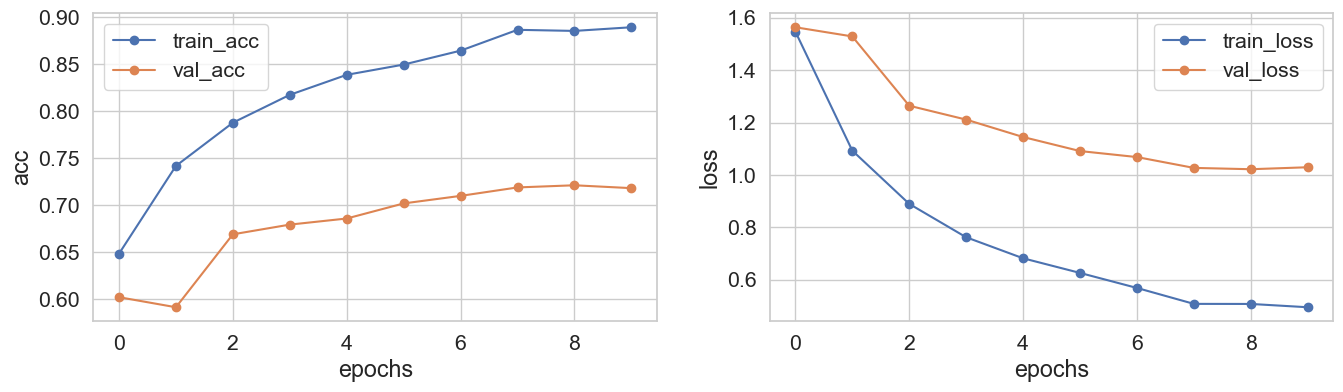

In [99]:
handle_history(history, "Inception v.3")

## ResNet

In [141]:
model_extractor = models.resnet101(pretrained=True)

C:\Users\Vlad\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Vlad\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\Vlad/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100%|███████████████████████████████████████████████████████████████████████████████| 171M/171M [00:21<00:00, 8.39MB/s]


In [142]:
RESCALE_SIZE = 224

In [143]:
print(model_extractor)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [157]:
for param in model_extractor.parameters():
    param.requires_grad = False

In [158]:
for param in model_extractor.layer4.parameters():
    param.requires_grad = True

In [159]:
model_extractor.fc = nn.Linear(2048, n_classes)

In [160]:
model_extractor = model_extractor.cuda()

In [161]:
sampler = get_sampler(extended_train_dataset)

In [162]:
history = train(extended_train_dataset, val_dataset, model_extractor, epochs=20, batch_size=64, sampler=sampler, extended_val_dataset = extended_val_dataset, parameters=model_extractor.parameters())

Train dataset size: 28723
Validation dataset size: 5234
Extended validation dataset size: 3192


epoch:   5%|███▋                                                                     | 1/20 [03:45<1:11:22, 225.41s/it]


Epoch 001; 	 train_loss: 2.1846 val_loss 0.4936 ext_val_loss 0.5729;     train_acc 0.4129 val_acc 0.8655 ext_val_acc 0.8377;


epoch:  10%|███████▎                                                                 | 2/20 [07:22<1:06:05, 220.31s/it]


Epoch 002; 	 train_loss: 0.3181 val_loss 0.2248 ext_val_loss 0.2955;     train_acc 0.9129 val_acc 0.9398 ext_val_acc 0.9223;


epoch:  15%|██████████▉                                                              | 3/20 [11:00<1:02:09, 219.40s/it]


Epoch 003; 	 train_loss: 0.1658 val_loss 0.1629 ext_val_loss 0.2760;     train_acc 0.9556 val_acc 0.9566 ext_val_acc 0.9258;


epoch:  20%|███████████████                                                            | 4/20 [14:46<59:10, 221.91s/it]


Epoch 004; 	 train_loss: 0.1119 val_loss 0.1420 ext_val_loss 0.2775;     train_acc 0.9705 val_acc 0.9633 ext_val_acc 0.9336;


epoch:  25%|██████████████████▊                                                        | 5/20 [18:33<55:55, 223.72s/it]


Epoch 005; 	 train_loss: 0.0796 val_loss 0.1107 ext_val_loss 0.2794;     train_acc 0.9779 val_acc 0.9731 ext_val_acc 0.9386;


epoch:  30%|██████████████████████▌                                                    | 6/20 [22:20<52:27, 224.84s/it]


Epoch 006; 	 train_loss: 0.0641 val_loss 0.0881 ext_val_loss 0.2488;     train_acc 0.9825 val_acc 0.9769 ext_val_acc 0.9439;


epoch:  35%|██████████████████████████▎                                                | 7/20 [26:06<48:50, 225.43s/it]


Epoch 007; 	 train_loss: 0.0452 val_loss 0.0648 ext_val_loss 0.2503;     train_acc 0.9874 val_acc 0.9836 ext_val_acc 0.9449;


epoch:  40%|██████████████████████████████                                             | 8/20 [29:54<45:15, 226.30s/it]


Epoch 008; 	 train_loss: 0.0124 val_loss 0.0303 ext_val_loss 0.1774;     train_acc 0.9974 val_acc 0.9939 ext_val_acc 0.9665;


epoch:  45%|█████████████████████████████████▊                                         | 9/20 [33:42<41:34, 226.81s/it]


Epoch 009; 	 train_loss: 0.0065 val_loss 0.0275 ext_val_loss 0.1837;     train_acc 0.9988 val_acc 0.9945 ext_val_acc 0.9646;


epoch:  50%|█████████████████████████████████████                                     | 10/20 [37:28<37:44, 226.41s/it]


Epoch 010; 	 train_loss: 0.0051 val_loss 0.0249 ext_val_loss 0.1807;     train_acc 0.9993 val_acc 0.9956 ext_val_acc 0.9680;


epoch:  55%|████████████████████████████████████████▋                                 | 11/20 [41:16<34:03, 227.03s/it]


Epoch 011; 	 train_loss: 0.0041 val_loss 0.0272 ext_val_loss 0.2001;     train_acc 0.9995 val_acc 0.9950 ext_val_acc 0.9640;


epoch:  60%|████████████████████████████████████████████▍                             | 12/20 [44:59<30:05, 225.72s/it]


Epoch 012; 	 train_loss: 0.0028 val_loss 0.0219 ext_val_loss 0.1817;     train_acc 0.9995 val_acc 0.9960 ext_val_acc 0.9687;


epoch:  65%|████████████████████████████████████████████████                          | 13/20 [48:43<26:15, 225.04s/it]


Epoch 013; 	 train_loss: 0.0020 val_loss 0.0224 ext_val_loss 0.1928;     train_acc 0.9998 val_acc 0.9966 ext_val_acc 0.9674;


epoch:  70%|███████████████████████████████████████████████████▊                      | 14/20 [52:26<22:26, 224.43s/it]


Epoch 014; 	 train_loss: 0.0021 val_loss 0.0210 ext_val_loss 0.1895;     train_acc 0.9998 val_acc 0.9966 ext_val_acc 0.9687;


epoch:  75%|███████████████████████████████████████████████████████▌                  | 15/20 [56:03<18:31, 222.32s/it]


Epoch 015; 	 train_loss: 0.0007 val_loss 0.0203 ext_val_loss 0.1916;     train_acc 0.9999 val_acc 0.9968 ext_val_acc 0.9693;


epoch:  80%|███████████████████████████████████████████████████████████▏              | 16/20 [59:39<14:41, 220.34s/it]


Epoch 016; 	 train_loss: 0.0012 val_loss 0.0203 ext_val_loss 0.1953;     train_acc 0.9998 val_acc 0.9969 ext_val_acc 0.9693;


epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [1:03:14<10:56, 218.72s/it]


Epoch 017; 	 train_loss: 0.0006 val_loss 0.0200 ext_val_loss 0.1959;     train_acc 0.9999 val_acc 0.9966 ext_val_acc 0.9690;


epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [1:06:49<07:15, 217.55s/it]


Epoch 018; 	 train_loss: 0.0010 val_loss 0.0199 ext_val_loss 0.1983;     train_acc 0.9998 val_acc 0.9968 ext_val_acc 0.9693;


epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [1:10:25<03:37, 217.32s/it]


Epoch 019; 	 train_loss: 0.0008 val_loss 0.0197 ext_val_loss 0.1981;     train_acc 0.9999 val_acc 0.9966 ext_val_acc 0.9684;


epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [1:14:08<00:00, 222.40s/it]


Epoch 020; 	 train_loss: 0.0014 val_loss 0.0196 ext_val_loss 0.2006;     train_acc 0.9999 val_acc 0.9969 ext_val_acc 0.9684;


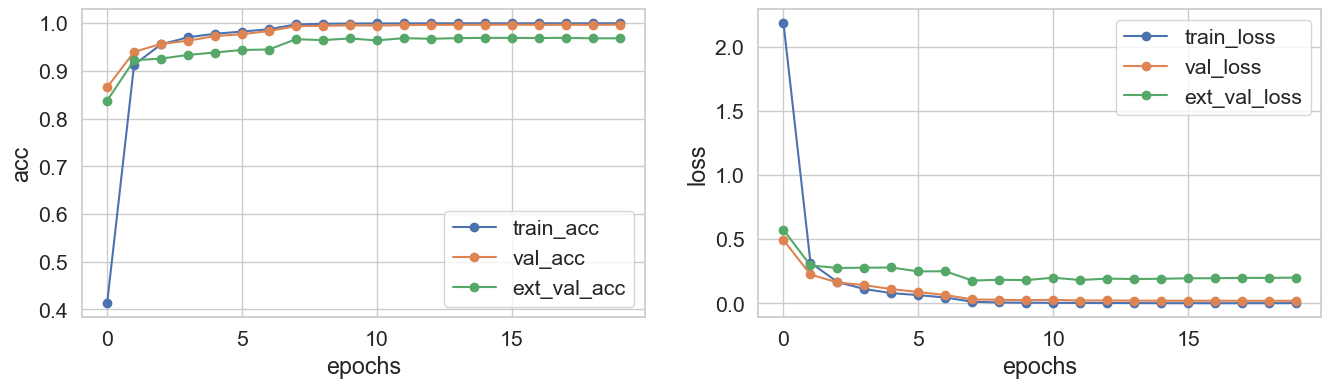

In [163]:
handle_history(history, 'ResNet101, pretrained, last layer retraining')

In [164]:
torch.save(model_extractor.state_dict(), 'ResNet101.pth')

batch: 100%|███████████████████████████████████████████████████████████████████████████| 82/82 [00:33<00:00,  2.44it/s]


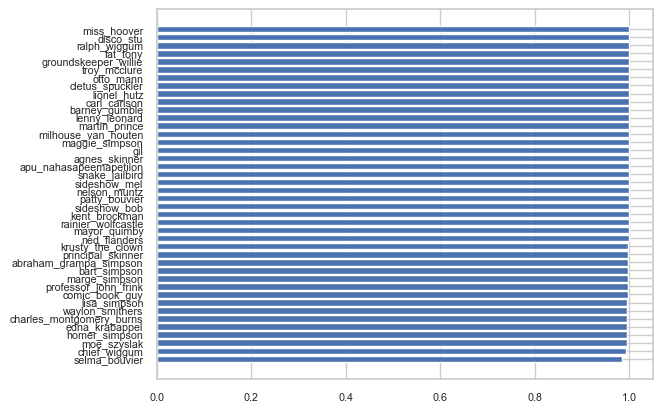

In [165]:
analyze_model(model_extractor, val_dataset)

In [166]:
submit(model_extractor, "ResNet101.csv")

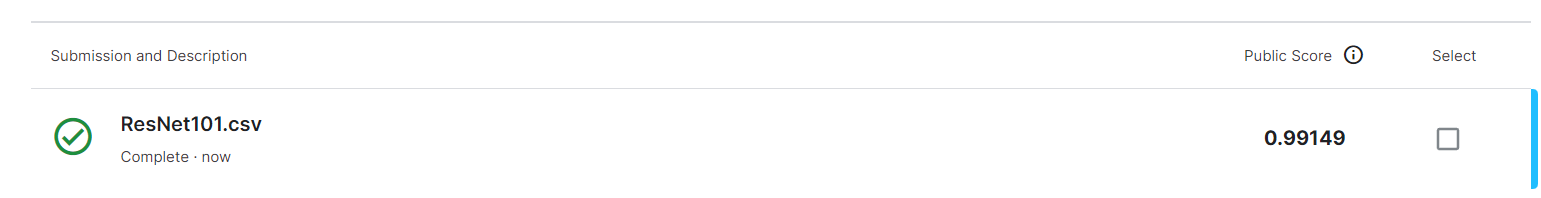